In [12]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt


In [13]:

# Define constants
IMAGE_WIDTH, IMAGE_HEIGHT = 128, 128
BATCH_SIZE = 32
EPOCHS = 20
NUM_CLASSES = 7


In [14]:

DATA_DIR = "/home/qod120/Documents/project/2nd_ai_web_project/ai_model/Cat Emotions.v2i.multiclass/train"
CSV_FILE = os.path.join(DATA_DIR, "_classes.csv")
PRETRAINED_MODEL_PATH = "cat_emotion_mobilenet_model_v1.h5"
FINE_TUNED_MODEL_PATH = "cat_emotion_mobilenet_finetuned_v2.h5"


In [15]:

def create_mobilenet_model(input_shape, num_classes):
    base_model = MobileNetV2(input_shape=input_shape, include_top=False, weights='imagenet')
    base_model.trainable = False  # Freeze the convolutional base

    inputs = tf.keras.Input(shape=input_shape)
    x = base_model(inputs, training=False)
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation='sigmoid')(x)
    model = Model(inputs, outputs)
    return model


In [16]:

def load_data(csv_file, data_dir, image_width, image_height):
    df = pd.read_csv(csv_file)
    
    class_columns = df.columns.drop('filename').tolist()
    
    df['filename'] = df['filename'].apply(lambda x: os.path.join(data_dir, x))
    
    return df, class_columns


In [17]:

def prepare_data(csv_file, data_dir, image_width, image_height, batch_size):
    df, class_columns = load_data(csv_file, data_dir, image_width, image_height)
    
    df = df.sample(frac=1, random_state=42).reset_index(drop=True)
    
    validation_split_ratio = 0.2
    validation_samples = int(len(df) * validation_split_ratio)
    
    train_df = df.iloc[validation_samples:]
    validation_df = df.iloc[:validation_samples]
    
    num_classes = len(class_columns)
    
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=30,
        width_shift_range=0.3,
        height_shift_range=0.3,
        shear_range=0.3,
        zoom_range=0.3,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    validation_datagen = ImageDataGenerator(rescale=1./255)

    train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_df,
        x_col='filename',
        y_col=class_columns,
        target_size=(image_width, image_height),
        batch_size=batch_size,
        class_mode='raw',
        shuffle=True
    )

    validation_generator = validation_datagen.flow_from_dataframe(
        dataframe=validation_df,
        x_col='filename',
        y_col=class_columns,
        target_size=(image_width, image_height),
        batch_size=batch_size,
        class_mode='raw',
        shuffle=False
    )
    return train_generator, validation_generator, class_columns, num_classes


In [18]:

def build_and_compile_finetune_model(input_shape, num_classes, pretrained_model_path):
    model = tf.keras.models.load_model(pretrained_model_path)
    
    # Unfreeze the base model for fine-tuning
    for layer in model.layers:
        if isinstance(layer, tf.keras.Model) and layer.name.startswith('mobilenetv2'):
            layer.trainable = True
            
    model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),  # Lower learning rate for fine-tuning
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    model.summary()
    return model


In [19]:

def train_and_save_model(model, train_generator, validation_generator, epochs, batch_size):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    history = model.fit(
        train_generator,
        steps_per_epoch=int(np.ceil(train_generator.samples / batch_size)),
        epochs=epochs,
        validation_data=validation_generator,
        validation_steps=int(np.ceil(validation_generator.samples / batch_size)),
        callbacks=[early_stopping]
    )
    model.save(FINE_TUNED_MODEL_PATH)
    print(f"Model trained and saved as {FINE_TUNED_MODEL_PATH}")
    return history


In [20]:

def evaluate_and_display_predictions(model_path, validation_generator, class_columns):
    loaded_model = tf.keras.models.load_model(model_path)

    validation_images, validation_labels = next(validation_generator)
    predictions = loaded_model.predict(validation_images)

    plt.figure(figsize=(10, 10))
    for i in range(min(9, len(validation_images))):
        plt.subplot(3, 3, i + 1)
        plt.imshow(validation_images[i])
        true_label = class_columns[np.argmax(validation_labels[i])].replace('Unlabeled', 'No Emotion')
        # For multi-label classification with sigmoid, a threshold (e.g., 0.5) should be applied to predictions
        # to determine all present labels. For simplicity in display, we're showing the label with the highest probability.
        predicted_label = class_columns[np.argmax(predictions[i])].replace('Unlabeled', 'No Emotion')
        plt.title(f"True: {true_label}\nPred: {predicted_label}")
        plt.axis('off')
    plt.show()


Found 1657 validated image filenames.
Found 414 validated image filenames.


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_128            │ (None, 4, 4, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 512)            │       655,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 7)              │         3,591 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,917,447 (11.13 MB)

 Trainable params: 2,883,335 (11.00 MB)

 Non-trainable params: 34,112 (133.25 KB)

Epoch 1/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 53s 704ms/step - accuracy: 0.6663 - loss: 0.2784 - val_accuracy: 0.6087 - val_loss: 0.4907
Epoch 2/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 35s 674ms/step - accuracy: 0.6856 - loss: 0.2647 - val_accuracy: 0.6256 - val_loss: 0.4757
Epoch 3/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 35s 673ms/step - accuracy: 0.6729 - loss: 0.2673 - val_accuracy: 0.6280 - val_loss: 0.4568
Epoch 4/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 38s 728ms/step - accuracy: 0.6711 - loss: 0.2651 - val_accuracy: 0.6353 - val_loss: 0.4414
Epoch 5/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 36s 692ms/step - accuracy: 0.7067 - loss: 0.2508 - val_accuracy: 0.6498 - val_loss: 0.4255
Epoch 6/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 35s 676ms/step - accuracy: 0.6946 - loss: 0.2497 - val_accuracy: 0.6498 - val_loss: 0.4047
Epoch 7/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 35s 669ms/step - accuracy: 0.7109 - loss: 0.2450 - val_accuracy: 0.6643 - val_loss: 0.3886
Epoch 8/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 35s 669ms/step - accuracy: 0.7061 - loss: 0.2456 - val_accu

Model trained and saved as cat_emotion_mobilenet_finetuned_v2.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 784ms/step


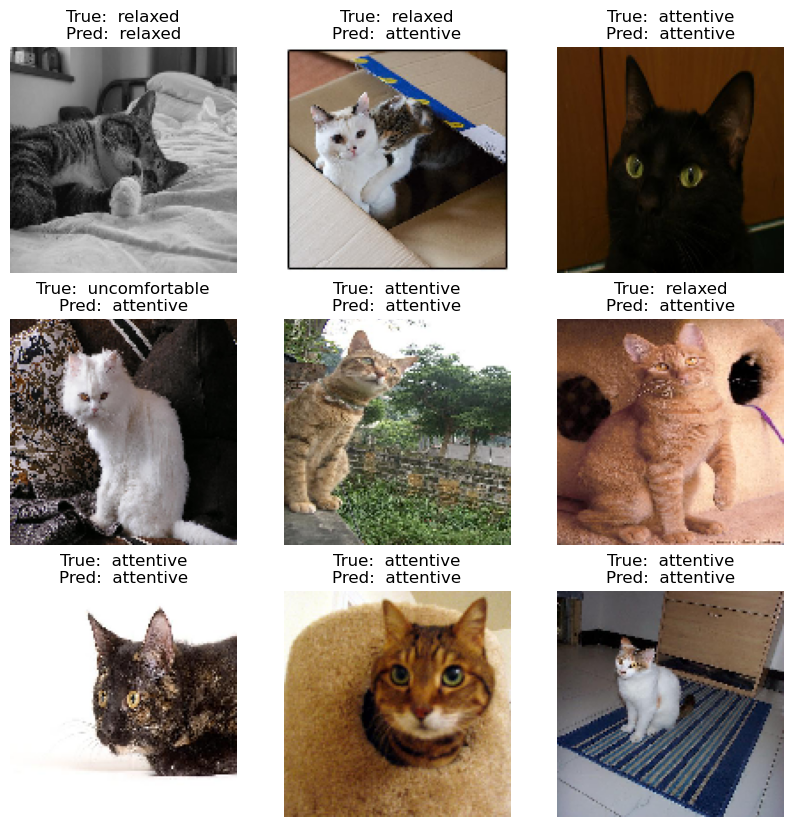

In [21]:

def train_model():
    train_generator, validation_generator, class_columns, num_classes = prepare_data(
        CSV_FILE, DATA_DIR, IMAGE_WIDTH, IMAGE_HEIGHT, BATCH_SIZE
    )
    
    model = build_and_compile_finetune_model((IMAGE_WIDTH, IMAGE_HEIGHT, 3), num_classes, PRETRAINED_MODEL_PATH)
    
    train_and_save_model(model, train_generator, validation_generator, EPOCHS, BATCH_SIZE)
    
    evaluate_and_display_predictions(FINE_TUNED_MODEL_PATH, validation_generator, class_columns)

if __name__ == "__main__":
    train_model()
